In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
x_train = pd.read_csv('./x_train.csv')
y_train = pd.read_csv('./y_train.csv')

**Let's first analyze our data**

In [3]:
x_train.head()

,the,to,ect,and,for,of,a,you,hou,in,...,enhancements,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry
0,2,5,2,0,2,0,24,1,0,4,...,0,0,0,0,0,0,0,0,0,0
1,18,15,2,1,4,14,120,5,0,15,...,0,0,0,0,0,0,0,0,2,0
2,2,0,1,1,2,2,12,2,0,3,...,0,0,0,0,0,0,0,0,1,0
3,26,31,2,13,12,23,222,1,0,65,...,0,0,0,0,5,0,0,0,0,0
4,1,1,1,2,0,0,10,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
x_train.shape

(4137, 3000)

In [5]:
y_train.head()

,Prediction
0,0
1,0
2,1
3,1
4,1


0    2954
1    1183
Name: Prediction, dtype: int64

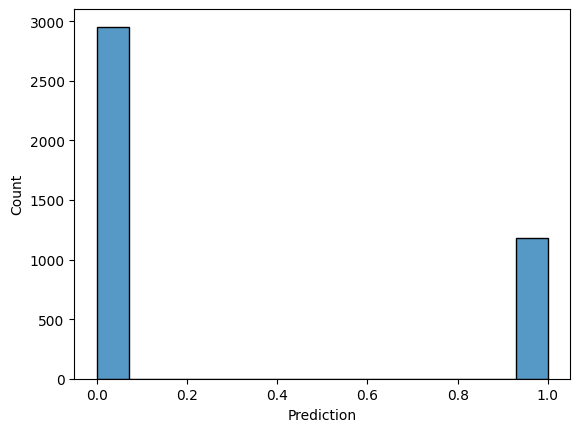

In [6]:
sns.histplot(y_train['Prediction'])
# as we can see, non-spam mails are almost twice as much as the spam ones (unbalanced)
y_train.Prediction.value_counts()

# **2- Train**
In this part, define two methods:
*   For calculating the prior probability of a given label *y*, 
*   For calculating the numerator of conditional probability *P(x_j | y)*\
 -> i.e. number of occurences of a word in the specified labeled datas
*   For calculating the denominator of conditional probability *P(x_j | y)*\
 -> i.e. number of all the words in the specified labeled datas


**Prior:**

In [7]:
# Calculate prior of the given label
# gets Y and label as params, returns the prior
def calc_prior(Y, label):

    arr = Y.values
    size = Y.size

    if label == 1:
        return np.count_nonzero(arr) / size
    else:
        return (size - np.count_nonzero(arr)) / size

**Likelihood:**

In [8]:
def calc_likelihood(X, Y):
    single_spam = [] # idx 0 is total no of 'the' in all spam emails
    total_spam = 0 # total no of words in all spam emails
    single_safe = []
    total_safe = 0
    berno_spam = [] # idx 0 is total no of 'the' in all spam NOT including multiple in single email
    berno_safe = []

    x_combined = X.copy()
    x_combined['Prediction'] = Y
    x_spam = x_combined[x_combined['Prediction'] == 1]
    x_safe = x_combined[x_combined['Prediction'] == 0][:-1]
    x_spam = x_spam.values # convert to numpy
    x_safe = x_safe.values # convert to numpy
    x_spam = x_spam.transpose()[:-1] # to iterate word by word and drop Pred column
    x_safe = x_safe.transpose()[:-1] # to iterate word by word and drop Pred column


    for word in x_spam:
        total = word.sum()
        single_spam.append(total)
        total_spam += total
        berno_spam.append(np.count_nonzero(word))

    for word in x_safe:
        total = word.sum()
        single_safe.append(total)
        total_safe += total
        berno_safe.append(np.count_nonzero(word))

    return single_spam, total_spam, single_safe, total_safe, berno_spam, berno_safe

In [9]:
# calculate and store the estimators of the parameters in order not to calculate them again and again in each predict call
spam_numerator, spam_denominator, safe_numerator, safe_denominator, berno_spam, berno_safe = calc_likelihood(x_train, y_train)

# **3- Predict**


In [10]:
# read test files
x_test = pd.read_csv('./x_test.csv')
y_test = pd.read_csv('./y_test.csv')

In [11]:
x_test.head()

,the,to,ect,and,for,of,a,you,hou,in,...,enhancements,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry
0,1,1,1,0,1,0,6,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,4,17,3,5,3,64,1,7,12,...,0,0,0,0,0,0,0,0,1,0
3,0,2,3,5,1,2,30,0,1,3,...,0,0,0,0,0,0,0,0,1,0
4,10,18,3,9,2,3,60,0,0,15,...,0,0,0,0,0,0,0,0,3,0


In [12]:
x_test.shape

(1035, 3000)

In [13]:
y_test.head(-15)

,Prediction
0,0
1,0
2,0
3,1
4,0
...,...
1015,1
1016,0
1017,1
1018,0


In [14]:
import math
def predict_multinomial(X_train, Y_train, X_test, prior):

    np.seterr(divide='ignore')

    result = [] # prediciton of each instance of X_test will be stored here
    x_test_arr = X_test.values # convert to numpy array
    vocab_len = len(X_test.columns) # 3000

    # get prior P(spam) (spam = 1)
    prior_spam = calc_prior(Y_train, 1) 

    # get prior P(safe) (safe = 0)
    prior_safe = calc_prior(Y_train, 0)

    for instance in x_test_arr:

        arr_spam = np.array(spam_numerator)
        arr_safe = np.array(safe_numerator)

        # calculate likelihoods
        if prior == 0:
            arr_spam = arr_spam/spam_denominator # for spam
            arr_safe = arr_safe/safe_denominator # for safe
        else:
            arr_spam = (arr_spam + prior) / (spam_denominator + (prior*vocab_len))
            arr_safe = (arr_safe + prior) / (safe_denominator + (prior*vocab_len))
        arr_spam = np.log(arr_spam)
        arr_safe = np.log(arr_safe)
        arr_spam[np.isneginf(arr_spam)]= -1e+12
        arr_safe[np.isneginf(arr_safe)]= -1e+12
        arr_spam *= instance
        arr_safe *= instance

        # determine the final prediction
        if (np.sum(arr_spam) + math.log(prior_spam)) > (np.sum(arr_safe) + math.log(prior_safe)):
            result.append(1)
        else:
            result.append(0)
  
    
    return result




**Question 2.2:** \

Multinomial Naive Bayes



In [15]:
result_multinom = predict_multinomial(x_train, y_train, x_test, 0)

# **4- Examine Accuracy**


In [16]:
def calc_accuracy(predicted, truth):
    cnt = 0
    # variables to be used in confusion matrix
    tp = 0 # true positives
    fp = 0 # false positives
    fn = 0 # false negatives
    tn = 0 # true negatives
    for p, t in zip(predicted, truth):
        if p == t:
            cnt += 1
            if p == 0:
                tn += 1
            if p == 1:
                tp += 1
        else:
            if p == 0:
                fn += 1
            if p == 1:
                fp += 1
    print("Accuracy: ", cnt/len(predicted), " = %", 100*cnt/len(predicted))
    print("Number of wrong predictions: ", len(predicted) - cnt)
    print("Number of True Positives: ", tp)
    print("Number of False Positives: ", fp)
    print("Number of True Negatives: ", tn)
    print("Number of False Negatives: ", fn)

In [17]:
calc_accuracy(result_multinom, y_test["Prediction"]) # 0.9584541062801932

Accuracy:  0.9584541062801932  = % 95.84541062801932
Number of wrong predictions:  43
Number of True Positives:  289
Number of False Positives:  15
Number of True Negatives:  703
Number of False Negatives:  28


**Question 2.3:**

Multinomial Naive Bayes with Smoothing

In [18]:
result_multinom_smoothed = predict_multinomial(x_train, y_train, x_test, 5)

In [19]:
calc_accuracy(result_multinom_smoothed, y_test["Prediction"]) # 0.9478260869565217

Accuracy:  0.9478260869565217  = % 94.78260869565217
Number of wrong predictions:  54
Number of True Positives:  300
Number of False Positives:  37
Number of True Negatives:  681
Number of False Negatives:  17


**Question 2.4:**

Bernoulli Naive Bayes

In [20]:
# a simple method to return the number of spam and safe emails in the training set
def calc_total(Y):
    arr_y = Y.values
    non_zero_count = np.count_nonzero(arr_y)
    return non_zero_count, arr_y.size - non_zero_count

In [21]:
import math
def predict_bernoulli(Y_train, X_test):

    result = [] # prediciton of each instance of X_test will be stored here
    x_test_arr = X_test.values # convert to numpy array
    total_spam, total_safe = calc_total(Y_train)

    np.seterr(divide='ignore')

    # get prior P(spam) (spam = 1)
    prior_spam = calc_prior(Y_train, 1) 

    # get prior P(safe) (safe = 0)
    prior_safe = calc_prior(Y_train, 0)

    spam_log = np.array(berno_spam)
    spam_log = spam_log / total_spam
    safe_log = np.array(berno_safe)
    safe_log = safe_log / total_safe

    for instance in x_test_arr:

        arr_spam = instance.copy() # deep copy
        arr_safe = instance.copy() # deep copy

        arr_spam = np.where(arr_spam == 0, 1-spam_log, spam_log)
        arr_safe = np.where(arr_safe == 0, 1-safe_log, safe_log)

        arr_spam = np.log(arr_spam)
        arr_safe = np.log(arr_safe)
        arr_spam[np.isneginf(arr_spam)] = -1e+12
        arr_safe[np.isneginf(arr_safe)] = -1e+12

        # determine the final prediction
        if (np.sum(arr_spam) + math.log(prior_spam)) > (np.sum(arr_safe) + math.log(prior_safe)):
            result.append(1)
        else:
            result.append(0)

    return result




In [22]:
result_bernoulli = predict_bernoulli(y_train, x_test)

In [23]:
calc_accuracy(result_bernoulli, y_test["Prediction"])

Accuracy:  0.9207729468599034  = % 92.07729468599034
Number of wrong predictions:  82
Number of True Positives:  247
Number of False Positives:  12
Number of True Negatives:  706
Number of False Negatives:  70
